In this notebook we're testing how "strong" the regression model is , we will check if it can still can still predict correctly even if the data is a bit messy or has outliers.This is important to make sure our model works well on real world data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ml_project/final_feature_matrix.csv')

In [ ]:
orders=pd.read_csv('/content/drive/MyDrive/ml_project/orders.csv')

we added the orders file because since we're working on a new notbook we need to repeat the 'merge' step , we need the 'days_since_prior_order' column .

In [ ]:
orders_sorted=orders.sort_values(['user_id', 'order_number'])
last_orders=orders_sorted.groupby('user_id').tail(1)

In [ ]:
data = data.merge(last_orders[['user_id', 'days_since_prior_order']], on='user_id', how='inner')

In [ ]:
if len(data) > 200000:
    data = data.sample(n=200000, random_state=42)

In [ ]:
data.head()

,user_id,product_id,user_product_purchase_count,user_product_reorder_ratio,user_product_days_since_last_purchase,user_total_orders,user_reorder_ratio,user_avg_basket_size,user_mean_days_between_orders,user_days_since_last_order,log_user_total_orders,days_since_prior_order
10589486,163834,26283,3,0.666667,5.0,15,0.309091,7.333334,14.307693,30.0,2.772589,23.0
8128189,125629,28204,2,0.500000,30.0,11,0.616915,18.272728,12.145251,12.0,2.484907,30.0
11763256,182247,14183,3,0.666667,30.0,4,0.406250,8.000000,23.750000,30.0,1.609438,30.0
11247203,174134,20169,1,0.000000,NaN,13,0.547170,16.307692,9.632124,13.0,2.639057,4.0
6993533,107989,14429,1,0.000000,1.0,51,0.703470,12.431373,6.295161,7.0,3.951244,1.0


In [ ]:
print(data.isnull().sum())

user_id                                      0
product_id                                   0
user_product_purchase_count                  0
user_product_reorder_ratio                   0
user_product_days_since_last_purchase    13107
user_total_orders                            0
user_reorder_ratio                           0
user_avg_basket_size                         0
user_mean_days_between_orders                0
user_days_since_last_order                   0
log_user_total_orders                        0
days_since_prior_order                       0
dtype: int64


In [ ]:
data['days_since_prior_order'] = data['days_since_prior_order'].fillna(data['days_since_prior_order'].median())
data = data.fillna(0)

here we cleaned the data, so the model won't have problems.


In [ ]:
data['user_id'] = data['user_id'].astype('int32')
data['days_since_prior_order'] = data['days_since_prior_order'].astype('int8')

In [ ]:
y =data['days_since_prior_order']
X =data.drop(columns=['days_since_prior_order', 'user_id', 'product_id'])

splitting the data into features (X) and target (y)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

we split the data into 80% for training and 20% for testing,we are also using StandardScaler to make sure all features have the same scale, which helps the model perform better and makes it more stable.

In [ ]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
rf_robust=RandomForestRegressor(n_estimators=50,max_depth=10,random_state=42,n_jobs=-1)
rf_robust.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [ ]:
y_pred=rf_robust.predict(X_test_scaled)
base_mae=mean_absolute_error(y_test,y_pred)

 here we're training a Random Forest regressor to be my 'Baseline',after it learns from the clean data ,I will use its initial performance (MAE) to compare it with the noisy data later.

In [ ]:
print(f"Base Model MAE:{base_mae:.4f}")

Base Model MAE: 7.0213


The Base Model achieved an MAE of 7.0213 days, this indicates that our Random Forest model on average predicts the reorder time with a margin of error of about one week,so this is a reasonable starting point given the complexity of customer behavior.

In [ ]:
noise_factor=0.1
X_test_noisy=X_test_scaled + noise_factor*np.random.normal(size=X_test_scaled.shape)

We are adding random noise to the test set to perform a sensitivity analysis, which is required to check if our Random Forest model is "Robust-stable" or if it "collapses-error increases significantly" when the data is slightly mess.

In [ ]:
y_pred_noisy=rf_robust.predict(X_test_noisy)
noisy_mae=mean_absolute_error(y_test, y_pred_noisy)

In [ ]:
perf_drop=((noisy_mae - base_mae)/base_mae)*100

In [ ]:
{"Original MAE":round(base_mae, 4),"Noisy MAE":round(noisy_mae, 4),"Performance Drop (%)":f"{perf_drop:.2f}%"}

{'Original MAE': 7.0213, 'Noisy MAE': 7.2011, 'Performance Drop (%)': '2.56%'}

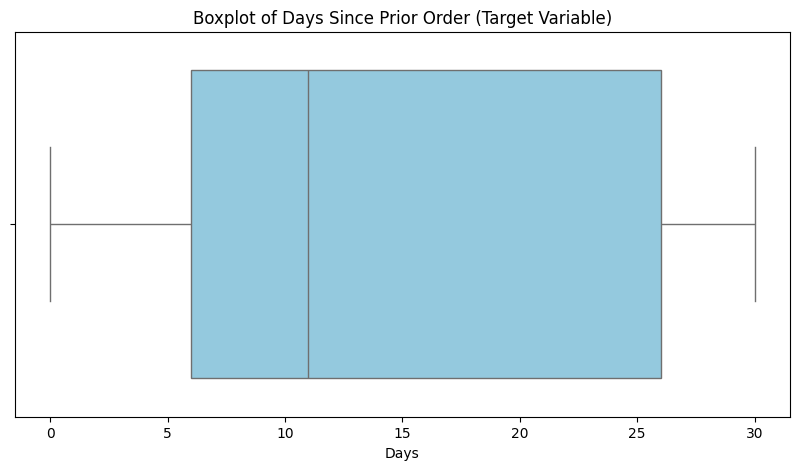

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['days_since_prior_order'],color='skyblue')
plt.title('Boxplot of Days Since Prior Order (Target Variable)')
plt.xlabel('Days')
plt.show()

this is a target variable outlier analysis-here we used a Boxplot to analyze the distribution of our target variable,days_since_prior_order.Visualizing the target is crucial for Robustness because extreme outliers can significantly skew the model's predictions and increase the MAE .
Some observations on the plot :


*   The median reorder time is approximately 11 days
*   Most orders occur within the 6 to 26 days range (Interquartile Range).
*   No extreme outliers are detected beyond the 30-day cap,which suggests our data is well-preprocessed and suitable for training a robust regressor.



